Imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import k3d
import os
import cv2

Helper functions:

In [2]:
def load_lidar_bin(file_path):
    """Load a .bin LiDAR file (KITTI format)."""
    points = np.fromfile(file_path, dtype=np.float32).reshape(-1, 4)
    return points[:, :3]



def plot_img(image_path_left, image_path_right, figsize=(22, 6)):
    """Function to plot two images side by side with a larger display."""
    try:
        img_left = mpimg.imread(image_path_left)
        img_right = mpimg.imread(image_path_right)

        if img_left.shape[0] != img_right.shape[0]:
            print("Warning: Images have different heights. Resizing is not supported in this function.")

        combined_img = np.hstack((img_left, img_right))

        plt.figure(figsize=figsize)
        plt.imshow(combined_img)
        plt.axis("off")
        plt.show()

    except FileNotFoundError as e:
        print(f"Error: File not found! - {e.filename}")

def extract_labels(file_path):
    columns = [
        "ObjectType", "Truncation", "Occlusion", "Alpha", 
        "X1", "Y1", "X2", "Y2",  # 2D bounding box (xmin, ymin, xmax, ymax)
        "H", "W", "L",           # 3D dimensions (height, width, length)
        "X", "Y", "Z",           # 3D location in camera coordinates
        "Rotation_Y"             # Rotation around Y-axis
    ]
    
    data = []
    
    with open(file_path, "r") as file:
        for line in file:
            values = line.strip().split()  # Split line by whitespace
            object_data = {
                columns[i]: values[i] if i == 0 else float(values[i])  # Keep ObjectType as string, rest as float
                for i in range(len(columns))
            }
            data.append(object_data)
    
    return pd.DataFrame(data)

def extract_matrices(filename):
    global P0, P1, P2, P3, R0_rect, Tr_velo_to_cam, Tr_cam_to_velo, Tr_imu_to_velo, Tr_velo_to_imu

    with open(filename, 'r') as file:
        for line in file:
            if line.strip():  # Negeer lege regels
                parts = line.split(':')
                key = parts[0].strip()
                values = np.fromstring(parts[1], sep=' ')

                if key.startswith("P"):
                    matrix = values.reshape(3, 4)
                elif key == "R0_rect":
                    matrix = values.reshape(3, 3)
                elif key in ["Tr_velo_to_cam", "Tr_imu_to_velo"]:
                    matrix_3x4 = values.reshape(3, 4)
                    bottom_row = np.array([[0, 0, 0, 1]])
                    matrix = np.vstack([matrix_3x4, bottom_row])

                    # Bereken de inverse en sla die ook op
                    inverse_matrix = np.linalg.inv(matrix)
                    if key == "Tr_velo_to_cam":
                        globals()["Tr_cam_to_velo"] = inverse_matrix
                    elif key == "Tr_imu_to_velo":
                        globals()["Tr_velo_to_imu"] = inverse_matrix
                else:
                    continue  # Onverwachte sleutel, sla over

                # Sla de matrix op als een globale variabele
                globals()[key] = matrix

def draw_3d_bbox(df):
    plot = k3d.plot()
    
    for _, row in df.iterrows():
        if row["ObjectType"] in ["DontCare"]:
            continue

        x, y, z = row["X"], row["Y"], row["Z"]
        w, h, l = row["W"], row["H"], row["L"]
        ry = row["Rotation_Y"]

        corners = np.array([
            [-l/2, -w/2, -h/2],  # Linksboven-achter
            [ l/2, -w/2, -h/2],  # Rechtsboven-achter
            [ l/2,  w/2, -h/2],  # Rechtsboven-voor
            [-l/2,  w/2, -h/2],  # Linksboven-voor
            [-l/2, -w/2,  h/2],  # Linksonder-achter
            [ l/2, -w/2,  h/2],  # Rechtsonder-achter
            [ l/2,  w/2,  h/2],  # Rechtsonder-voor
            [-l/2,  w/2,  h/2]   # Linksonder-voor
        ])

        # Rotatie om de Y-as
        cos_ry, sin_ry = np.cos(ry), np.sin(ry)
        rotation_matrix = np.array([
            [cos_ry, 0, sin_ry],
            [0, 1, 0],
            [-sin_ry, 0, cos_ry]
        ])
        
        # Pas rotatie en translatie toe
        rotated_corners = (rotation_matrix @ corners.T).T
        translated_corners = rotated_corners + np.array([x, y, z])

        # Verbindingslijnen voor 3D box
        edges = [
            (0, 1), (1, 2), (2, 3), (3, 0),  # Bodem
            (4, 5), (5, 6), (6, 7), (7, 4),  # Top
            (0, 4), (1, 5), (2, 6), (3, 7)   # Verticale lijnen
        ]
        
        # Creëer lijsten voor lijnen
        indices = []
        vertices = translated_corners.flatten().tolist()
        for edge in edges:
            indices.extend(edge)

        # Maak K3D object voor 3D box
        bbox = k3d.lines(
            vertices=vertices,
            indices=indices,
            shader="simple",
            width=2.0,
            color=0xff0000  # Rode kleur
        )
        
    return bbox


def transform_lidar_to_camera(lidar_points, Tr_velo_to_cam):
    # Stap 1: Voeg een extra kolom toe met 1's
    ones = np.ones((lidar_points.shape[0], 1))  # (N,1)
    lidar_homogeneous = np.hstack((lidar_points, ones))  # (N,4)

    # Stap 2: Pas de transformatie toe
    camera_points_homogeneous = lidar_homogeneous @ Tr_velo_to_cam.T  # (N,4)

    # Stap 3: Laat de homogene coördinaat vallen (alleen x, y, z behouden)
    camera_points = camera_points_homogeneous[:, :3]  # (N,3)

    return camera_points


def compute_3D_from_disparity(right_projection_matrix, disparity_img, R0_rect):
    """
    Bereken de 3D-coördinaten (X, Y, Z) vanuit een disparity afbeelding en pas rectificatie toe.

    Parameters:
    - right_projection_matrix: 3x4 projectiematrix van de rechter camera.
    - disparity_img: Grayscale disparity afbeelding (numpy array of PNG-bestandspad).
    - R0_rect: 3x3 rectificatiematrix.

    Returns:
    - xyz_img: (hoogte x breedte x 3) array met XYZ-coördinaten of `np.nan` voor ongeldige pixels.
    """

    # Controleer of disparity_img een bestandspad is en laad de afbeelding
    if isinstance(disparity_img, str):
        disparity_img = cv2.imread(disparity_img, cv2.IMREAD_UNCHANGED)  # Laad als 16-bits indien nodig
        if disparity_img is None:
            raise ValueError(f"Kan de afbeelding niet laden: {disparity_img}")
    
    # Controleer of het een 16-bits disparity map is en schaal indien nodig
    if disparity_img.dtype == np.uint16:
        disparity_img = disparity_img.astype(np.float32) / 256.0  # Schalen als de disparity in 16-bits is opgeslagen
    
    height, width = disparity_img.shape
    xyz_img = np.zeros((height, width, 3), dtype=np.float32)

    # Haal camera parameters uit de projectiematrix
    f = right_projection_matrix[0, 0]  # Focale lengte
    c_x = right_projection_matrix[0, 2]  # Optisch centrum X
    c_y = right_projection_matrix[1, 2]  # Optisch centrum Y
    T_x = right_projection_matrix[0, 3]  # Baseline (Tx is meestal negatief!)

    # Bereken de diepte Z
    no_occlusions = (disparity_img > 0)
    depth_img = np.full_like(disparity_img, np.nan, dtype=np.float32)
    depth_img[no_occlusions] = (-T_x) / disparity_img[no_occlusions]  # Diepte = baseline / disparity

    # Maak een raster van pixelcoördinaten
    u, v = np.meshgrid(np.arange(width), np.arange(height))

    # Camera frame (initiële 3D-coördinaten)
    X_cam = (u - c_x) * depth_img / f
    Y_cam = (v - c_y) * depth_img / f
    Z_cam = depth_img

    # Combineer XYZ-coördinaten in een Nx3 matrix
    xyz_flat = np.column_stack((X_cam.ravel(), Y_cam.ravel(), Z_cam.ravel()))  # (N, 3)

    # Pas rectificatie toe met R0_rect
    xyz_rect_flat = xyz_flat @ R0_rect.T  # Matrixvermenigvuldiging (3x3 rotatie)

    # Terugzetten naar (hoogte, breedte, 3) formaat
    xyz_img = xyz_rect_flat.reshape(height, width, 3)

    # Filter punten met Z > 20 meter
    mask = xyz_img[:, :, 2] > 17.5
    xyz_img[mask] = np.nan
    
    return xyz_img


Plotting the datapoints:


(115384, 3)


/home/feddepc/miniconda3/envs/pointcloud_env/lib/python3.10/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  warnings.warn(


Output()

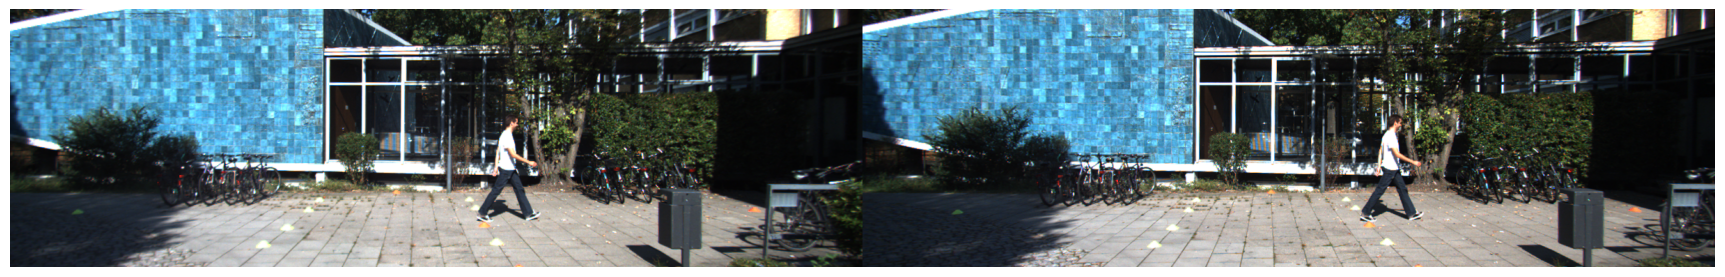

   ObjectType  Truncation  Occlusion  Alpha     X1     Y1      X2      Y2  \
0  Pedestrian         0.0        0.0   -0.2  712.4  143.0  810.73  307.92   

      H     W    L     X     Y     Z  Rotation_Y  
0  1.89  0.48  1.2  1.84  1.47  8.41        0.01  


In [ ]:
file_path_dataset = os.path.expanduser("~/computer_vision/Dataset")
lidar_relative_path = "/data_object_velodyne/training/velodyne/{:06d}.bin"
left_img_relative_path = "/data_object_image_2/training/image_2/{:06d}.png"
right_img_relative_path = "/data_object_image_3/training/image_3/{:06d}.png"
disparity_relative_path = "/disparity_images/disparity{:06d}.png"
labels_relative_path = "/data_object_label_2/training/label_2/{:06d}.txt"
calibration_relative_path ="/data_object_calib/training/calib/{:06d}.txt"

sequence_number = 0

lidar_path = file_path_dataset + lidar_relative_path.format(sequence_number)
left_img_path = file_path_dataset + right_img_relative_path.format(sequence_number)
right_img_path = file_path_dataset + left_img_relative_path.format(sequence_number)
disparity_path = file_path_dataset + disparity_relative_path.format(sequence_number)
labels_path = file_path_dataset + labels_relative_path.format(sequence_number)
calibration_path = file_path_dataset + calibration_relative_path.format(sequence_number)

lidar_points = load_lidar_bin(lidar_path)
print(lidar_points.shape)

labels = extract_labels(labels_path)
extract_matrices(calibration_path)

lidar_points_camera = transform_lidar_to_camera(lidar_points, Tr_velo_to_cam)


disparity_map = cv2.imread(disparity_path, cv2.IMREAD_GRAYSCALE)
disparity_map = disparity_map.astype(np.float32)

xyz_img = compute_3D_from_disparity(P3, disparity_map, R0_rect)

disp_pc = xyz_img.reshape(-1, 3)

disp_pc = disp_pc[~np.isnan(disp_pc).any(axis=1)]


Tr_cam3_to_cam2 = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0.5],
    [0, 0, 1, 1],
    [0, 0, 0, 1]
])

disp_pc = transform_lidar_to_camera(disp_pc, Tr_cam3_to_cam2)
#Plot the lidar points
plot = k3d.plot()
point_cloud = k3d.points(lidar_points_camera, point_size=0.05, color=0x0000ff)
plot += point_cloud
plot += k3d.points(positions=disp_pc, point_size=0.05, color=0x00ff00)

plot.display()

plot_img(left_img_path, right_img_path)
print(labels)


